# Classificazione dei Nodi con Graph Convolutional Network
A seguito spieghiamo come eseguire la classificazione dei nodi utilizzando la libreria StellarGraph. La libreria StellarGraph supporta molti algoritmi di machine learning (ML) all'avanguardia sui grafi. Addestreremo un modello per prevedere la classe o l'etichetta di un nodo, comunemente nota come classificazione dei nodi. Useremo il modello risultante anche per calcolare gli incorporamenti vettoriali per ogni nodo. Per creare il grafo utilizzeremo il dataset Cora, che è costituito da pubblicazioni accademiche come nodi e le citazioni tra loro come archi: se la pubblicazione A cita la pubblicazione B, il grafo avrà un arco dal nodo A al nodo B. I nodi sono classificati in uno dei sette campi accademici. Come algoritmo di addestramento sul grafo usiamo il Graph Convolutional Network (GCN).

In questo notebook passeremo attraverso tre sezioni:

Preparazione dei dati usando Pandas e scikit-learn: carichiamo il grafo dal file CSV e lo suddividiamo in parti di addestramento, test e convalida.
Creazione dei livelli GCN e input dei dati utilizzando StellarGraph.
Addestramento e valutazione del modello utilizzando TensorFlow Keras, Pandas e scikit-learn.

Il primo passo è importare le librerie Python di cui avremo bisogno.

In [ ]:
pip install stellargraph

In [2]:
import pandas as pd
import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import model_selection, preprocessing
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

# 1. Preparazione dei dati
## Caricamento della rete CORA
Possiamo recuperare il grafo del dataset Cora dalla libreria StellarGraph, utilizzando il pacchetto datasets, che contiene le classi per scaricare i dataset di esempio, e specificando il dataset da scaricare con il comando Cora(). 

Nota: Cora è una rete di citazioni, quindi è un grafo diretto, ma ignoriamo le direzioni degli archi e lo trattiamo come un grafo non orientato.

La documentazione con comandi necessari per caricare il dataset sono nel seguente indirizzo: https://stellargraph.readthedocs.io/en/stable/api.html#stellargraph.datasets.Cora 

In [3]:
dataset = sg.datasets.Cora()
display(HTML(dataset.description))

Il metodo info può aiutarci per confrontare se le info del dataset corrispondono con la descrizione.

In [4]:
G, node_subjects = dataset.load()
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)
        Features: none


Il metodo load() restituisce una tupla di due oggetti in cui il primo oggetto è il grafo con i nodi e i vettori con le caratteristiche dei nodi e degli archi, il secondo oggetto è un pandas.Series() con le etichette delle classi di appartenenza dei nodi.

Osserviamo il numero di nodi appartenenti a ciascuna classe con il seguente comando.

In [5]:
node_subjects.value_counts().to_frame()

,subject
Neural_Networks,818
Probabilistic_Methods,426
Genetic_Algorithms,418
Theory,351
Case_Based,298
Reinforcement_Learning,217
Rule_Learning,180


## Divisione dei Dati
Vogliamo prendere un sottoinsieme dei nodi per l'addestramento e utilizzare il resto dei nodi per la convalida e il test. Per farlo usiamo la funzione di scikit-learn train_test_split(), la sua documentazione è [qui](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

Con il parametro train_size specifichiamo su quanti nodi etichettati fare il training.

In [6]:
train_subjects, test_subjects = model_selection.train_test_split(node_subjects, train_size = 140, test_size=None, stratify=node_subjects)
train_subjects.shape, test_subjects.shape

((140,), (2568,))

Otteniamo così la suddivisione di 140 nodi per l'addestramento e i restanti nodi (2568) per il test. 

Di questi 2568 nodi decidiamo di usarne 500 per la convalida, e i restanti 2068 per il test.

In [7]:
val_subjects, test_subjects = model_selection.train_test_split(test_subjects, train_size=500, test_size=None, stratify=test_subjects)
val_subjects.shape, test_subjects.shape

((500,), (2068,))

Utilizzando il campionamento stratificato otteniamo i 140 nodi per il train classificati nel seguente modo:

In [8]:
train_subjects.value_counts().to_frame()

,subject
Neural_Networks,42
Genetic_Algorithms,22
Probabilistic_Methods,22
Theory,18
Case_Based,16
Reinforcement_Learning,11
Rule_Learning,9


Notiamo che l'insieme dei nodi scelti per il training presenta uno squilibrio nei ragguppamenti per classe, e questo potrebbe essere compensato. Tuttavia, ignoreremo questo squilibrio per semplicità.

## Conversione in array numerici
Per il nostro obiettivo categoriale, utilizzeremo vettori one-hot (vettori con 0 o 1) che verranno confrontati con l'output soft-max del modello (la funzione soft-max fornisce una distribuzione di probabilità delle classi di appartenenza).

Per fare questa conversione in vettori one-hot usiamo la trasformazione [LabelBinarizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html) di scikit-learn.



In [9]:
target_encoding = preprocessing.LabelBinarizer()
train_targets = target_encoding.fit_transform(train_subjects)
train_targets.shape

(140, 7)

Abbiamo creato 140 vettori one-hot di lunghezza 7 per ciascuno dei 140 nodi di train, dove c'è 1 indica la sua classe di appartenenza.
Procediamo analogamente con i nodi di convalida e di test.

In [10]:
val_targets = target_encoding.fit_transform(val_subjects)
test_targets = target_encoding.fit_transform(test_subjects)
val_targets.shape, test_targets.shape

((500, 7), (2068, 7))

Il dataset CORA contiene attributi w_x che corrispondono alle parole trovate in quella pubblicazione. Se una parola ricorre più di una volta in una pubblicazione, l'attributo relativo sarà impostato a 1, altrimenti sarà 0. Questi attributi numerici sono stati inclusi automaticamente con StellarGarph nell'istanza G, quindi non è necessario eseguire ulteriori conversioni.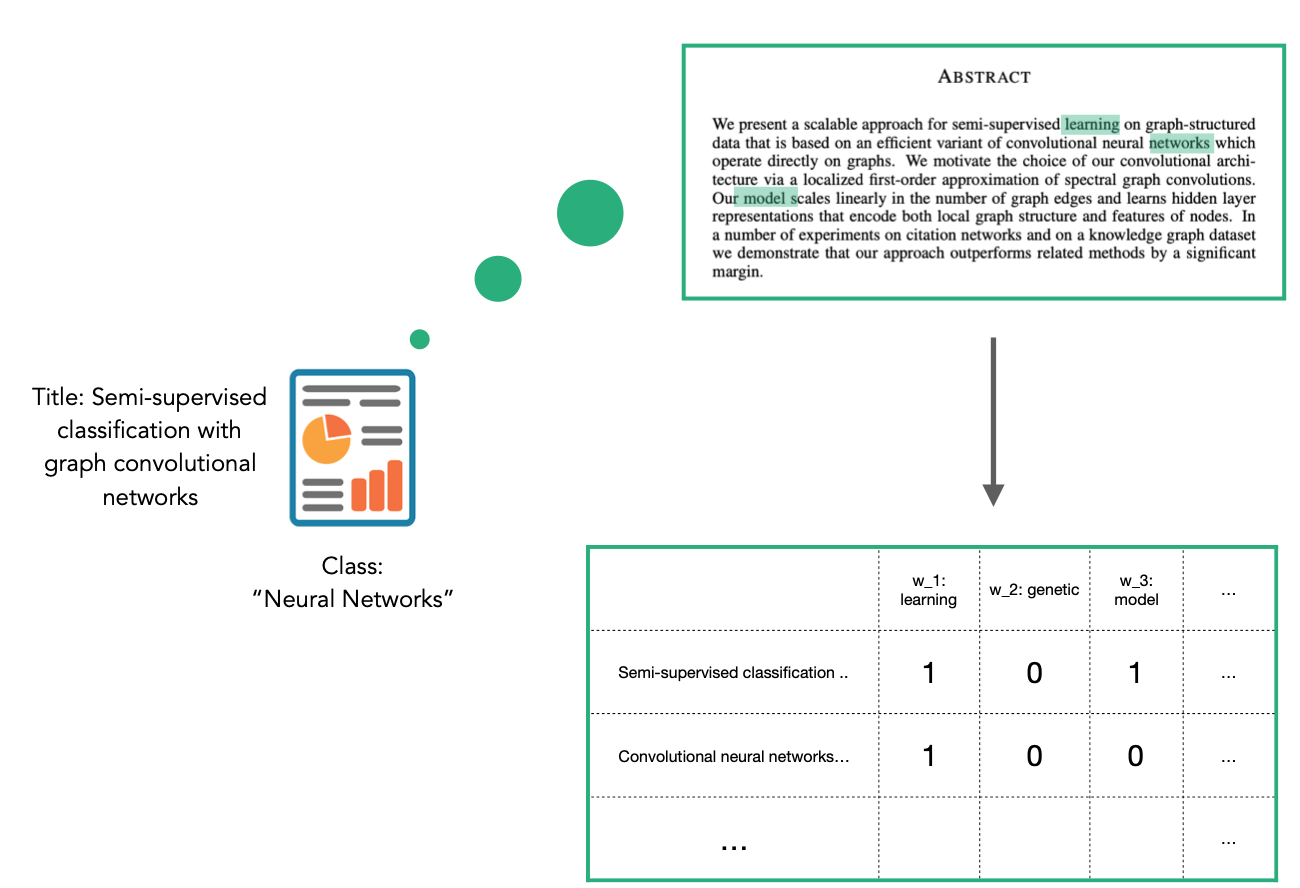


# 2. Creazione dei livelli della GCN
Un modello di machine learning in StellarGraph è costituito da una coppia di elementi:


*   Gli strati, come la convoluzione del grafo.
*   Un generatore di dati per convertire la struttura del grafo principale e le caratteristiche dei nodi in un formato che può essere inserito nel modello Keras per l'addestramento o la previsione.

GCN è un modello full-batch, cioè che come le reti neurali semplici viene addestrato con una serie di epoche (forward + backpropagation) su tutti gli esempi di training, inoltre il nostro compito è fare previsioni sulla classificazione dei nodi, perciò [FullBatchNodeGenerator](https://stellargraph.readthedocs.io/en/stable/api.html#stellargraph.mapper.FullBatchNodeGenerator) è il generatore appropriato per la nostra attività. 

Specificando l'argomento method='gcn' si normalizza la matrice di adiacenza del grafo catturando la struttura del grafo e producendo i dati appropriati per l'algoritmo GCN.



In [11]:
generator = FullBatchNodeGenerator(G, method='gcn')

Using GCN (local pooling) filters...


Chiamando il metodo flow() con un insieme di nodi e le loro etichette produce un oggetto che può essere usato per addestrare il modello, sui nodi ed etichette che sono stati specificati. Abbiamo creato un set di addestramento sopra, lo useremo qui.

In [12]:
train_gen = generator.flow(train_subjects.index, train_targets)

Ora possiamo specificare il nostro modello di ML creando uno stack di livelli.
Possiamo usare la classe [GCN](https://stellargraph.readthedocs.io/en/stable/api.html#stellargraph.layer.GCN) di StellarGraph, che impacchetta la creazione di questo stack di convoluzione del grafo e i livelli di dropout. 

Possiamo specificare alcuni parametri per controllare questo:


*   layer_sizes: il numero di livelli nascosti della GCN e la loro dimensione, in questo caso, due livelli GCN con 16 unità ciascuno.
*   activations: l'attivazione da appllicare all'output di ogni livello GCN. in questo caso usiamo la ReLu per entrambi i livelli.
*  dropout: il tasso di abbandono per l'input di ogni livello GCN. In questo caso il 50%.


In [13]:
gcn = GCN(layer_sizes=[16, 16], activations=["relu", "relu"], generator=generator, dropout=0.5)

Per creare un modello Keras esponiamo i tensori di input e di output del modello GCN per la previsione dei nodi, tramite il metodo GCN.in_out_tensors. 

In [14]:
x_inp, x_out = gcn.in_out_tensors()
x_inp, x_out

([<KerasTensor: shape=(1, 2708, 1433) dtype=float32 (created by layer 'input_1')>,
  <KerasTensor: shape=(1, None) dtype=int32 (created by layer 'input_2')>,
  <KerasTensor: shape=(1, None, 2) dtype=int64 (created by layer 'input_3')>,
  <KerasTensor: shape=(1, None) dtype=float32 (created by layer 'input_4')>],
 <KerasTensor: shape=(1, None, 16) dtype=float32 (created by layer 'gather_indices')>)

Il valore di x_out è un tensore dell'output del modello GCN che contiene un vettore 16-dimensional  per i nodi richiesti durante l'addestramento o la previsione. Le previsioni effettive della classe di ogni nodo devono essere calcolate da questo vettore. StellaGraph è costruita utilizzando la funzionalità Keras, quindi questo può essere fatto con una funzionalità standard di Keras: aggiungiamo uno strato denso (fully connected) con un'unità per ciascuna classe (7) utilizzando un'attivazione softmax. Questa funzione di attivazione assicura che gli output finali saranno un vettore di probabilità, dove ogni valore è compreso tra 0 e 1, e l'intero vettore somma a 1. La classe prevista è l'elemento con il valore più alto.

In [15]:
predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

# 3. Training e Valutazione
## Addestramento del modello
Ora creiamo il [modello Keras](https://www.tensorflow.org/api_docs/python/tf/keras/Model) effettivo con in tensori di input (x_inp) e i tensori di output che sono le previsioni (predictions) dallo strato denso finale. Il nostro compito è un compito di previsione categoriale, quindi una funzione di perdita di entropia incrociata categoriale è appropriata. Anche se stiamo usando un grafo con StellarGraph, stiamo lavorando con i valori di pervsione di Keras convenzionali, quindi possiamo usare la funzione di perdita di Keras.


In [16]:
model = Model(inputs=x_inp, outputs=predictions)

Una volta creato il modello, è possibile configurarlo per l'addestramento utilizzando il metodo compile. In questo caso utilizziamo come ottimizzatore per aggiustare i parametri l'algoritmo "Adam" con un learning rate di 0.01, la entropia incrociata categoriale come funzione di perdita e la accuracy come metrica che misura la correttezza del modello.

In [17]:
model.compile(
    optimizer=optimizers.Adam(lr=0.01),
    loss=losses.categorical_crossentropy,
    metrics=["acc"]
)

Mentre stiamo addestrando il modello, vorremo anche tenere traccia delle sue prestazioni di generalizzazione sul set di convalida, il che significa creare un'altro generatore di dati, usando FullBatchNodeGenerator come abbiamo fatto sul set di train.

In [18]:
val_gen = generator.flow(val_subjects.index, val_targets)

Possiamo utilizzare la funzionalità EarlyStopping di Keras per interrompere l'addestramento se l'accuracy della convalida smette di migliorare.

In [19]:
from tensorflow.keras.callbacks import EarlyStopping
es_callback = EarlyStopping(monitor="val_acc", patience=50, restore_best_weights=True)

Ora abbiamo impostato i livelli del modello, i dati di addestramento, i dati di convalida, e persino i callback di addestramento, quindi ora possiamo addestrare il modello usando il metodo [fit](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) del modello. Questo metodo addestra il modello per un numero fisso di epoche.

In [20]:
history = model.fit(
    train_gen,
    epochs=200,
    validation_data = val_gen,
    verbose=2,
    shuffle=False,
    callbacks=[es_callback]
)

Epoch 1/200
1/1 - 2s - loss: 1.9710 - acc: 0.1000 - val_loss: 1.9364 - val_acc: 0.2040
Epoch 2/200
1/1 - 0s - loss: 1.9357 - acc: 0.2286 - val_loss: 1.9236 - val_acc: 0.2060
Epoch 3/200
1/1 - 0s - loss: 1.9106 - acc: 0.2500 - val_loss: 1.9038 - val_acc: 0.1900
Epoch 4/200
1/1 - 0s - loss: 1.8874 - acc: 0.2429 - val_loss: 1.8811 - val_acc: 0.1880
Epoch 5/200
1/1 - 0s - loss: 1.8428 - acc: 0.2143 - val_loss: 1.8527 - val_acc: 0.2000
Epoch 6/200
1/1 - 0s - loss: 1.8203 - acc: 0.2500 - val_loss: 1.8154 - val_acc: 0.2220
Epoch 7/200
1/1 - 0s - loss: 1.7472 - acc: 0.3429 - val_loss: 1.7713 - val_acc: 0.2760
Epoch 8/200
1/1 - 0s - loss: 1.7184 - acc: 0.3143 - val_loss: 1.7226 - val_acc: 0.3600
Epoch 9/200
1/1 - 0s - loss: 1.6349 - acc: 0.4214 - val_loss: 1.6726 - val_acc: 0.4000
Epoch 10/200
1/1 - 0s - loss: 1.6180 - acc: 0.4786 - val_loss: 1.6211 - val_acc: 0.4660
Epoch 11/200
1/1 - 0s - loss: 1.5238 - acc: 0.5143 - val_loss: 1.5686 - val_acc: 0.5040
Epoch 12/200
1/1 - 0s - loss: 1.4261 - ac

Dopo aver addestrato il modello, possiamo visualizzare il comportamento della funzione di perdita e di qualsiasi altra metrica utilizzando la funzione "plot_history". In questo caso, osserviamo la perdita e l'accuratezza sia sul set di addestramento che su quello di convalida.

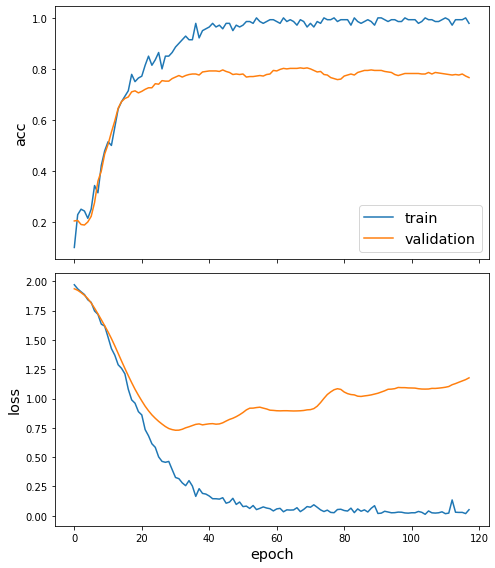

In [21]:
sg.utils.plot_history(history)

Come parte finale della valutazione, controlliamo il modello rispetto al set di test. Creiamo nuovamente i dati richiesti utilizzando il metodo flow di FullBatchNodeGenerator e poi usiamo il metodo [evaluate](https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate) che restituisce il valore di perdita ei i valori delle metriche per il modello in modalità test.

In [22]:
test_gen = generator.flow(test_subjects.index, test_targets)

In [23]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
  print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 58ms/step - loss: 1.0417 - acc: 0.7776

Test Set Metrics:
	loss: 1.0417
	acc: 0.7776


## Fare previsioni con il modello
Creiamo i dati richiesti per fare le previsioni su tutti i nodi con il metodo flow di FullBatchNodeGenerator, dopodiché usiamo il metodo [predict](https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict) per generare le previsioni su tutti i nodi del grafo. In questo caso, non forniamo le etichette al metodo flow poichè dobbiamo prevederle.

In [24]:
all_gen = generator.flow(node_subjects.index)
all_predictions = model.predict(all_gen)

Queste previsioni sono l'output della funzione soft-max, quindi per ottenere le categorie finali utilizziamo il metodo inverse_transform della classe target.encoder definita precedentemente.
Si noti che per i metodi full-batch la dimensione del batch è 1 e le previsioni hanno forma (1, N nodes, N classes) quindi rimuoviamo la dimensione batch per ottenere previsioni di forma matriciale (N nodes, N classes), cioè una matrice (2708, 7), utilizzando il metodo squeeze di NumPy che serve per rimuovere gli assi di lunghezza 1.

In [25]:
node_predictions = target_encoding.inverse_transform(all_predictions.squeeze())

In [26]:
df = pd.DataFrame({"Predicted": node_predictions, "True": node_subjects})
df.head(20)

,Predicted,True
31336,Neural_Networks,Neural_Networks
1061127,Rule_Learning,Rule_Learning
1106406,Reinforcement_Learning,Reinforcement_Learning
13195,Reinforcement_Learning,Reinforcement_Learning
37879,Probabilistic_Methods,Probabilistic_Methods
1126012,Probabilistic_Methods,Probabilistic_Methods
1107140,Theory,Theory
1102850,Neural_Networks,Neural_Networks
31349,Neural_Networks,Neural_Networks
1106418,Theory,Theory


# Incorporamento dei nodi
Oltre a prevedere solo la classe dei nodi, può essere utile ottenere un quadro più dettagliato delle informazioni che il modello ha appreso sui nodi e sui loro vicinati. In questo caso significa creare gli incorporamenti dei nodi in una spazio vettoriale che catturi tali informazioni, si presenta sotto forma di una tabella di ricerca che associa/mappa i nodi a dei vettori di numeri, o sotto forma di una rete neurale che produce questi vettori per ciascun nodo.
Per GCN, utilizziamo la seconda opzione, utilizzando l'ultimo livello di convoluzione del grafo del modello GCN (chiamato x_out), prima di applicare il livello di previsione.


Possiamo visualizzare questi incorporamenti come punti su un grafico, colorati dalle loro vere etichette. Se il modello ha appreso informazioni utili sui nodi in base alla loro classe, ci aspettiamo di vedere dei cluster di documenti/nodi nello spazio di incorporamento dei nodi, con i documenti della stessa classe appartenenti allo stesso cluster.

Per creare un modello che calcola gli incorporamenti dei nodi, utilizziamo gli stessi tensori di input (x_inp) del modello di previsione che abbiamo fatto prima e sostituiamo il tensore di output con quello GCN (x_out) invece di quello di previsione.

Questi tensori sono collegati agli stessi livelli e pesi che abbiamo addestrato durante l'addestramento delle predizioni, quindi stiamo usando questo modello solo per calcolare i vettori di incorporamento dei nodi.

Come abbiamo fatto per calcolare le previsioni per ogni nodo, calcoleremo gli incorporamenti per ogni nodo utilizzando i dati all_gen.

In [27]:
embedding_model = Model(inputs=x_inp, outputs= x_out)
emb = embedding_model.predict(all_gen)
emb.shape

(1, 2708, 16)

L'ultimo livello delle rete GCN ha dimensione di output 16, il che significa che ogni incorporamento è composto da 16 numeri. Mappare questi incorporamenti direttamente richiederebbe un grafico a 16 dimensioni, che è difficile da visualizzare per gli esseri umani. Possiamo proiettare questi incorporamenti fino a soli due numeri, creando vettori bidimensionali che possono essere mappati su un normale grafico di dispersione 2D.

Ci sono molti strumenti per questo compito di riduzione della dimensionalità , molti dei quali sono offerti da scikit-learn. I due più comuni sono [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) e [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html). TSNE è più lento ma in genere fornisce risultati migliori.


In [28]:
from sklearn.manifold import TSNE
transform = TSNE

Gli incorporamenti dei nodi clacolati con il modello GCN hanno dimensione (1, 2708, 16), per togliere la dimensione del batch usiamo il metodo squeeze(), così facendo otteniamo una matrice (N nodes, N emb) cioè (2708, 16). 

In [29]:
X = emb.squeeze()
X.shape

(2708, 16)

Quindi abbiamo preparato gli incorporamenti ad alta dimensione e scelta la trasformazione per la loro riduzione di dimensione, ora calcoliamo i vettori ridotti, ottenendo per ciascun nodo due nuovi valori.

In [30]:
trans = transform(n_components=2)
X_reduced = trans.fit_transform(X)
X_reduced.shape

(2708, 2)

I valori di X_reduced contengono una coppia di numeri per ogni nodo, nello stesso ordine della serie con gli id e le etichette dei nodi node_subjects.
Questo è sufficiente per creare un grafico di dispersione dei nodi con i colori.

[Text(0, 0.5, '$X_2$'),
 Text(0.5, 0, '$X_1$'),
 Text(0.5, 1.0, 'TSNE visualization of GCN embeddings for cora dataset'),
 None]

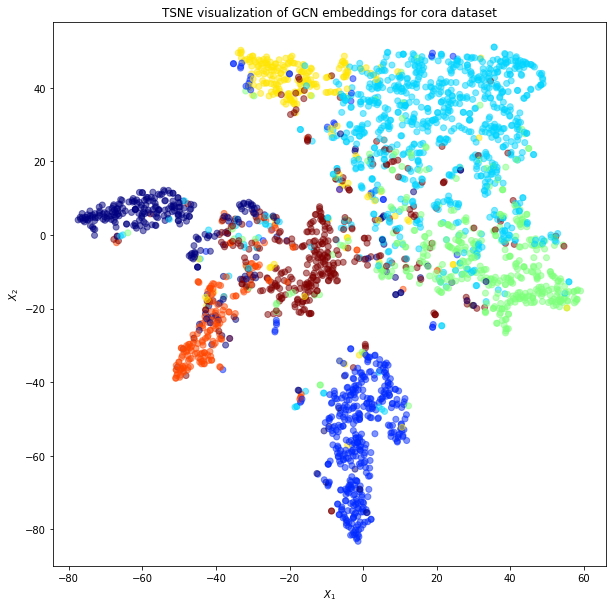

In [31]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    c=node_subjects.astype("category").cat.codes,
    cmap="jet",
    alpha=0.5,
)
ax.set(
    aspect="equal",
    xlabel="$X_1$",
    ylabel="$X_2$",
    title=f"{transform.__name__} visualization of GCN embeddings for cora dataset",
)

Osserviamo dal grafico un buon raggruppamento, in cui i nodi appartenenti alla stessa classe (stesso colore) sono per lo più raggruppati assieme.

# Conclusioni
Abbiamo visto come prevedere la classe dei nodi utilizzando l'algoritmo GCN.
In particolare come prevedere le calssi dei documenti accademici del dataset CORA.
Una volta addestrato il modello per le previsioni, abbiamo:


*   Calcolato le previsioni delle classi dei nodi
*   Utilizzato i pesi del modello per calcolare gli incorporamenti vettoriali per ciasciun nodo, e creato un grafico di dispersione per analizzare come sono stati mappati gli incorporamenti dei nodi nello spazio di embedding.

